## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# save model checkpoints
!mkdir ./ckpts

In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("./resnet3d")
from resnet3d import generate_model

### Config

In [3]:
LR = 1e-4
EPOCHS = 70
BATCH_SIZE = 32
CROP_SIZE = 256
Z_START = 24
Z_DIMS = 16
TRAIN_FRAGMENTS = ["2", "1"]
TEST_FRAGMENT = "3"

### Load data

In [4]:


FRAGMENTS_ZARR = {
    "1" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-1.zarr", mode="r"),
    "2" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-2.zarr", mode="r"),
    "3" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

### Visualise input

In [5]:
fragment = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000

fragment_cropped = fragment.surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, Z_START:Z_START+Z_DIMS]
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

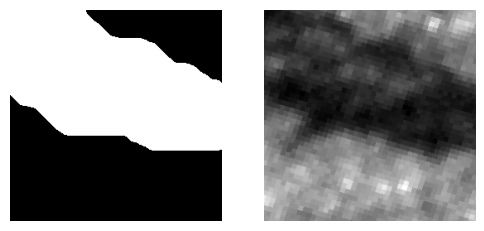

In [6]:
mask_cropped = fragment.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
del fragment, fragment_cropped, mask_cropped, ir_cropped
gc.collect()

4093

### Dataloaders

In [8]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# class VesuviusTrain(Dataset):
#     def __init__(self, fragments):
#         self.fragments = fragments
#         self.xys = []
        
#         for fragment in fragments:
#             H, W = FRAGMENTS_SHAPE[fragment]
#             for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
#                 for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
#                     self.xys.append((fragment, x, y, W, H))
        
#         train_aug_list = [
#                 # A.RandomResizedCrop(
#                 #     size, size, scale=(0.85, 1.0)),
#                 A.HorizontalFlip(p=0.5),
#                 A.VerticalFlip(p=0.5),
#                 A.RandomBrightnessContrast(p=0.75),
#                 A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(size * 0.1), 
#                                 mask_fill_value=0, p=0.5),
#                 A.ShiftScaleRotate(p=0.75),
#                 A.Rotate(limit=90, p=0.9), 
#                 A.OneOf([
#                         A.GaussNoise(var_limit=[10, 50]),
#                         A.GaussianBlur(),
#                         A.MotionBlur(),
#                         ], p=0.4),
#                 A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
#                 A.Cutout(max_h_size=int(size * 0.6),
#                          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
#                 A.Normalize(
#                     mean= [0] * Z_DIMS,
#                     std= [1] * Z_DIMS
#                 ),
#                 ToTensorV2(transpose_mask=True),
#             ]
        
        
        
#     def __getitem__(self, i):
#         fragment, x1, y1, W, H = self.xys[i]
#         z1, z2 = Z_START, Z_START+Z_DIMS
        
#         x_offset = random.randint(-32 if x1 != 0 else 0, 32)
#         y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
#         x1 += x_offset
#         y1 += y_offset
        
#         x2 = x1 + CROP_SIZE
#         y2 = y1 + CROP_SIZE
        
#         if x2 > W:
#             x1 -= x_offset
#             x2 -= x_offset
            
#         if y2 > H:
#             y1 -= y_offset
#             y2 -= y_offset
        
#         frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
#         mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
#         if random.random() > 0.5:
#             frag_crop = np.flip(frag_crop, axis=1).copy()
#             mask_crop = np.flip(mask_crop, axis=1).copy()

#         frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
#         frag_crop = frag_crop/65535.0
#         frag_crop = (frag_crop - 0.45)/0.225
        
#         mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        
        
        
        
        
        
        
        
#         return frag_crop, mask_crop

#     def __len__(self):
#         return len(self.xys)

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment in fragments:
            H, W = FRAGMENTS_SHAPE[fragment]
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    surface = FRAGMENTS_ZARR[fragment].surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, 0]
                    if np.sum(surface) / (CROP_SIZE * CROP_SIZE) > 0.2:
                        self.xys.append((fragment, x, y, W, H))
        
        self.train_aug_list = [
                # A.RandomResizedCrop(
                #     size, size, scale=(0.85, 1.0)),
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                
                # A.RandomBrightnessContrast(p=0.75),
                A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(CROP_SIZE * 0.1), 
                                mask_fill_value=0, p=0.5),
                # A.ShiftScaleRotate(p=0.75),
                
                A.Rotate(limit=90, p=0.9), 
                
                # A.OneOf([
                #         A.GaussNoise(var_limit=[0.01, 0.05]),
                #         A.GaussianBlur(blur_limit=(3, 5), sigma_limit=0),
                #         A.MotionBlur(blur_limit=3),
                #         ], p=0.8),
                # A.GridDistortion(num_steps=1, distort_limit=0.1, p=0.5),
                # A.MultiplicativeNoise(per_channel=True, multiplier=(0.95, 1.05)),
                
                # A.Cutout(max_h_size=int(CROP_SIZE * 0.2),
                #          max_w_size=int(CROP_SIZE * 0.2), num_holes=1, p=1.0),
                
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.train_aug_list)
        
        
        
    def __getitem__(self, i):
        fragment, x1, y1, W, H = self.xys[i]
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        x_offset = random.randint(-128 if x1 != 0 else 0, 128)
        y_offset = random.randint(-128 if y1 != 0 else 0, 128)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
        
        frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
        # if random.random() > 0.5:
        #     frag_crop = np.flip(frag_crop, axis=1).copy()
        #     mask_crop = np.flip(mask_crop, axis=1).copy()

        # Perform train augmentations

        frag_crop = frag_crop/65535.0
        
        
        # Apply the augmentations
        augmented = self.augmentations(image=frag_crop, mask=mask_crop)

        # Separate the image and mask
        frag_crop, mask_crop = augmented["image"], augmented["mask"]

        # normalize
        
        # frag_crop = (frag_crop - 0.45)/0.225
        
        frag_crop = frag_crop.unsqueeze(0) 
        mask_crop = mask_crop.float().unsqueeze(0)
        
        
        return frag_crop, mask_crop

    def __len__(self):
        return len(self.xys)

In [10]:
class VesuviusVal(Dataset):
    def __init__(self, fragment):
        self.fragment = FRAGMENTS_ZARR[fragment]
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = self.fragment.surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = self.fragment.truth[y1:y2, x1:x2]

        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
        frag_crop = frag_crop/65535.0
        # frag_crop = (frag_crop - 0.45)/0.225
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        return frag_crop, mask_crop, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [11]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=True, pin_memory=True, drop_last=True)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=False, pin_memory=True, drop_last=False)
n_valid = len(dataloader_valid)

In [12]:
i = random.randint(0, len(dataset_train))
i=30
img = dataset_train[i][0]
img.min(), img.max()

(tensor(0., dtype=torch.float64), tensor(1., dtype=torch.float64))

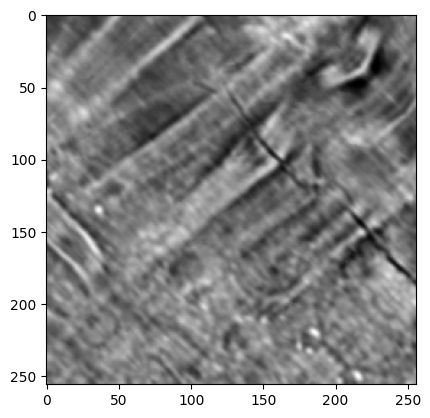

In [13]:
img_2 = img.squeeze(0).permute(1, 2, 0).numpy()
plt.imshow(img_2[:, :, 0], cmap="gray")

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [14]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = generate_model(model_depth=34, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))

In [15]:
model = SegModel()
model.load_pretrained_weights(torch.load("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/r3d18_K_200ep.pth")["state_dict"])
model = nn.DataParallel(model, device_ids=[0])

model = model.cuda()

_IncompatibleKeys(missing_keys=['layer1.2.conv1.weight', 'layer1.2.bn1.weight', 'layer1.2.bn1.bias', 'layer1.2.bn1.running_mean', 'layer1.2.bn1.running_var', 'layer1.2.conv2.weight', 'layer1.2.bn2.weight', 'layer1.2.bn2.bias', 'layer1.2.bn2.running_mean', 'layer1.2.bn2.running_var', 'layer2.2.conv1.weight', 'layer2.2.bn1.weight', 'layer2.2.bn1.bias', 'layer2.2.bn1.running_mean', 'layer2.2.bn1.running_var', 'layer2.2.conv2.weight', 'layer2.2.bn2.weight', 'layer2.2.bn2.bias', 'layer2.2.bn2.running_mean', 'layer2.2.bn2.running_var', 'layer2.3.conv1.weight', 'layer2.3.bn1.weight', 'layer2.3.bn1.bias', 'layer2.3.bn1.running_mean', 'layer2.3.bn1.running_var', 'layer2.3.conv2.weight', 'layer2.3.bn2.weight', 'layer2.3.bn2.bias', 'layer2.3.bn2.running_mean', 'layer2.3.bn2.running_var', 'layer3.2.conv1.weight', 'layer3.2.bn1.weight', 'layer3.2.bn1.bias', 'layer3.2.bn1.running_mean', 'layer3.2.bn1.running_var', 'layer3.2.conv2.weight', 'layer3.2.bn2.weight', 'layer3.2.bn2.bias', 'layer3.2.bn2.run

In [16]:
x = torch.randn(5, 1, 16, 256, 256).cuda()
with torch.no_grad():
    y = model(x)
y.shape

torch.Size([5, 1, 256, 256])

### Competition metric (F0.5 Score)

In [17]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [18]:
scaler = amp.GradScaler()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                steps_per_epoch=10, epochs=EPOCHS//10,
                                                pct_start=0.1)

In [19]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [20]:
import logging

logging.basicConfig(filename="training_log.txt", level=logging.INFO)


In [21]:
fbeta_best = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    




    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
        
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
    scheduler.step()
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    for threshold in np.arange(0.2, 0.85, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
        
        if fbeta_best < fbeta:
            fbeta_best = fbeta
            torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best_{fbeta_best:.4f}.pt")
    
    
    if epoch >= 10:
        torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")

    # if epoch == 30:
    #     break

    print()

Epoch 1/70  Mem : 17.4GB  LR : 4.00E-06  Loss: 0.7242: 100%|██████████| 64/64 [00:40<00:00,  1.60it/s]                                                                                                                                                                         
Val Loss: 0.6435: 100%|██████████| 19/19 [00:05<00:00,  3.29it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.102723
Threshold : 0.25	FBeta : 0.103443
Threshold : 0.30	FBeta : 0.104893
Threshold : 0.35	FBeta : 0.108259
Threshold : 0.40	FBeta : 0.114120
Threshold : 0.45	FBeta : 0.119880
Threshold : 0.50	FBeta : 0.117230
Threshold : 0.55	FBeta : 0.057474
Threshold : 0.60	FBeta : 0.004515
Threshold : 0.65	FBeta : 0.000071
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 2/70  Mem : 21.8GB  LR : 1.04E-05  Loss: 0.6251: 100%|██████████| 64/64 [00:39<00:00,  1.64it/s]                                                                                                                                                                         
Val Loss: 0.5558: 100%|██████████| 19/19 [00:05<00:00,  3.25it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.107264
Threshold : 0.25	FBeta : 0.114192
Threshold : 0.30	FBeta : 0.123478
Threshold : 0.35	FBeta : 0.132802
Threshold : 0.40	FBeta : 0.141596
Threshold : 0.45	FBeta : 0.143208
Threshold : 0.50	FBeta : 0.086713
Threshold : 0.55	FBeta : 0.006810
Threshold : 0.60	FBeta : 0.000014
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 3/70  Mem : 21.8GB  LR : 2.80E-05  Loss: 0.5508: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s]                                                                                                                                                                         
Val Loss: 13.6519: 100%|██████████| 19/19 [00:05<00:00,  3.31it/s]                                                                                                                                                                                                             

Threshold : 0.20	FBeta : 0.104151
Threshold : 0.25	FBeta : 0.105860
Threshold : 0.30	FBeta : 0.107723
Threshold : 0.35	FBeta : 0.100461
Threshold : 0.40	FBeta : 0.074406
Threshold : 0.45	FBeta : 0.032919
Threshold : 0.50	FBeta : 0.013023
Threshold : 0.55	FBeta : 0.006533
Threshold : 0.60	FBeta : 0.004660
Threshold : 0.65	FBeta : 0.003193
Threshold : 0.70	FBeta : 0.002330
Threshold : 0.75	FBeta : 0.001283
Threshold : 0.80	FBeta : 0.000255




Epoch 4/70  Mem : 21.8GB  LR : 5.20E-05  Loss: 0.5148: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                         
Val Loss: 0.4340: 100%|██████████| 19/19 [00:05<00:00,  3.28it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.103067
Threshold : 0.25	FBeta : 0.110072
Threshold : 0.30	FBeta : 0.139616
Threshold : 0.35	FBeta : 0.185554
Threshold : 0.40	FBeta : 0.215438
Threshold : 0.45	FBeta : 0.220431
Threshold : 0.50	FBeta : 0.055060
Threshold : 0.55	FBeta : 0.000000
Threshold : 0.60	FBeta : 0.000000
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 5/70  Mem : 21.8GB  LR : 7.60E-05  Loss: 0.4901: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s]                                                                                                                                                                         
Val Loss: 0.3469: 100%|██████████| 19/19 [00:05<00:00,  3.27it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.162884
Threshold : 0.25	FBeta : 0.171442
Threshold : 0.30	FBeta : 0.189517
Threshold : 0.35	FBeta : 0.221840
Threshold : 0.40	FBeta : 0.235029
Threshold : 0.45	FBeta : 0.247518
Threshold : 0.50	FBeta : 0.038230
Threshold : 0.55	FBeta : 0.000000
Threshold : 0.60	FBeta : 0.000000
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 6/70  Mem : 21.8GB  LR : 9.36E-05  Loss: 0.4751: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s]                                                                                                                                                                         
Val Loss: 0.4064: 100%|██████████| 19/19 [00:05<00:00,  3.29it/s]                                                                                                                                                                                                              

Threshold : 0.20	FBeta : 0.131467
Threshold : 0.25	FBeta : 0.162745
Threshold : 0.30	FBeta : 0.180268
Threshold : 0.35	FBeta : 0.195583
Threshold : 0.40	FBeta : 0.204504
Threshold : 0.45	FBeta : 0.229847
Threshold : 0.50	FBeta : 0.060729
Threshold : 0.55	FBeta : 0.000000
Threshold : 0.60	FBeta : 0.000000
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000




Epoch 7/70  Mem : 21.8GB  LR : 1.00E-04  Loss: 0.4608: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s]                                                                                                                                                                         
Val Loss: 0.3455: 100%|██████████| 19/19 [00:05<00:00,  3.28it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.162317
Threshold : 0.25	FBeta : 0.182397
Threshold : 0.30	FBeta : 0.213475
Threshold : 0.35	FBeta : 0.232783
Threshold : 0.40	FBeta : 0.249195
Threshold : 0.45	FBeta : 0.277064
Threshold : 0.50	FBeta : 0.270222
Threshold : 0.55	FBeta : 0.000000
Threshold : 0.60	FBeta : 0.000000
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 8/70  Mem : 21.8GB  LR : 9.99E-05  Loss: 0.4552: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s]                                                                                                                                                                         
Val Loss: 0.4031: 100%|██████████| 19/19 [00:05<00:00,  3.28it/s]                                                                                                                                                                                                              

Threshold : 0.20	FBeta : 0.157200
Threshold : 0.25	FBeta : 0.161245
Threshold : 0.30	FBeta : 0.167919
Threshold : 0.35	FBeta : 0.174522
Threshold : 0.40	FBeta : 0.198852
Threshold : 0.45	FBeta : 0.242079
Threshold : 0.50	FBeta : 0.222478
Threshold : 0.55	FBeta : 0.002350
Threshold : 0.60	FBeta : 0.000000
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000




Epoch 9/70  Mem : 21.8GB  LR : 9.98E-05  Loss: 0.4342: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                         
Val Loss: 0.2793: 100%|██████████| 19/19 [00:05<00:00,  3.29it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.227775
Threshold : 0.25	FBeta : 0.294599
Threshold : 0.30	FBeta : 0.342951
Threshold : 0.35	FBeta : 0.359073
Threshold : 0.40	FBeta : 0.357095
Threshold : 0.45	FBeta : 0.326776
Threshold : 0.50	FBeta : 0.241000
Threshold : 0.55	FBeta : 0.116738
Threshold : 0.60	FBeta : 0.024390
Threshold : 0.65	FBeta : 0.002130
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 10/70  Mem : 21.8GB  LR : 9.94E-05  Loss: 0.4252: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.2919: 100%|██████████| 19/19 [00:05<00:00,  3.26it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.215634
Threshold : 0.25	FBeta : 0.255860
Threshold : 0.30	FBeta : 0.292150
Threshold : 0.35	FBeta : 0.317873
Threshold : 0.40	FBeta : 0.334814
Threshold : 0.45	FBeta : 0.340228
Threshold : 0.50	FBeta : 0.330455
Threshold : 0.55	FBeta : 0.301764
Threshold : 0.60	FBeta : 0.235434
Threshold : 0.65	FBeta : 0.167612
Threshold : 0.70	FBeta : 0.092403
Threshold : 0.75	FBeta : 0.042535
Threshold : 0.80	FBeta : 0.017329



Epoch 11/70  Mem : 21.8GB  LR : 9.90E-05  Loss: 0.4144: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s]                                                                                                                                                                        
Val Loss: 0.2857: 100%|██████████| 19/19 [00:05<00:00,  3.29it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.211476
Threshold : 0.25	FBeta : 0.228875
Threshold : 0.30	FBeta : 0.251047
Threshold : 0.35	FBeta : 0.271742
Threshold : 0.40	FBeta : 0.299816
Threshold : 0.45	FBeta : 0.328158
Threshold : 0.50	FBeta : 0.346544
Threshold : 0.55	FBeta : 0.340388
Threshold : 0.60	FBeta : 0.283671
Threshold : 0.65	FBeta : 0.204421
Threshold : 0.70	FBeta : 0.121751
Threshold : 0.75	FBeta : 0.056234
Threshold : 0.80	FBeta : 0.023944



Epoch 12/70  Mem : 21.8GB  LR : 9.85E-05  Loss: 0.3995: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.3986: 100%|██████████| 19/19 [00:05<00:00,  3.27it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.187217
Threshold : 0.25	FBeta : 0.199517
Threshold : 0.30	FBeta : 0.208348
Threshold : 0.35	FBeta : 0.217096
Threshold : 0.40	FBeta : 0.236971
Threshold : 0.45	FBeta : 0.257869
Threshold : 0.50	FBeta : 0.278184
Threshold : 0.55	FBeta : 0.302319
Threshold : 0.60	FBeta : 0.327871
Threshold : 0.65	FBeta : 0.355613
Threshold : 0.70	FBeta : 0.378557
Threshold : 0.75	FBeta : 0.394978
Threshold : 0.80	FBeta : 0.397816



Epoch 13/70  Mem : 21.8GB  LR : 9.78E-05  Loss: 0.3928: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s]                                                                                                                                                                        
Val Loss: 0.2456: 100%|██████████| 19/19 [00:05<00:00,  3.30it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.316953
Threshold : 0.25	FBeta : 0.361683
Threshold : 0.30	FBeta : 0.387254
Threshold : 0.35	FBeta : 0.399740
Threshold : 0.40	FBeta : 0.415583
Threshold : 0.45	FBeta : 0.422016
Threshold : 0.50	FBeta : 0.421685
Threshold : 0.55	FBeta : 0.411185
Threshold : 0.60	FBeta : 0.386402
Threshold : 0.65	FBeta : 0.346557
Threshold : 0.70	FBeta : 0.289523
Threshold : 0.75	FBeta : 0.217849
Threshold : 0.80	FBeta : 0.153126



Epoch 14/70  Mem : 21.8GB  LR : 9.70E-05  Loss: 0.3769: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.3096: 100%|██████████| 19/19 [00:05<00:00,  3.25it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.193475
Threshold : 0.25	FBeta : 0.228098
Threshold : 0.30	FBeta : 0.259753
Threshold : 0.35	FBeta : 0.288043
Threshold : 0.40	FBeta : 0.334205
Threshold : 0.45	FBeta : 0.367551
Threshold : 0.50	FBeta : 0.393646
Threshold : 0.55	FBeta : 0.415106
Threshold : 0.60	FBeta : 0.441650
Threshold : 0.65	FBeta : 0.465339
Threshold : 0.70	FBeta : 0.473812
Threshold : 0.75	FBeta : 0.460683
Threshold : 0.80	FBeta : 0.399536



Epoch 15/70  Mem : 21.8GB  LR : 9.61E-05  Loss: 0.3735: 100%|██████████| 64/64 [00:40<00:00,  1.59it/s]                                                                                                                                                                        
Val Loss: 0.2269: 100%|██████████| 19/19 [00:05<00:00,  3.25it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.443471
Threshold : 0.25	FBeta : 0.479115
Threshold : 0.30	FBeta : 0.487119
Threshold : 0.35	FBeta : 0.480789
Threshold : 0.40	FBeta : 0.458903
Threshold : 0.45	FBeta : 0.418570
Threshold : 0.50	FBeta : 0.358944
Threshold : 0.55	FBeta : 0.285517
Threshold : 0.60	FBeta : 0.220233
Threshold : 0.65	FBeta : 0.157762
Threshold : 0.70	FBeta : 0.095048
Threshold : 0.75	FBeta : 0.047951
Threshold : 0.80	FBeta : 0.015067



Epoch 16/70  Mem : 21.8GB  LR : 9.50E-05  Loss: 0.3713: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s]                                                                                                                                                                        
Val Loss: 0.2461: 100%|██████████| 19/19 [00:05<00:00,  3.28it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.273640
Threshold : 0.25	FBeta : 0.318782
Threshold : 0.30	FBeta : 0.360075
Threshold : 0.35	FBeta : 0.392300
Threshold : 0.40	FBeta : 0.423000
Threshold : 0.45	FBeta : 0.446957
Threshold : 0.50	FBeta : 0.465208
Threshold : 0.55	FBeta : 0.471535
Threshold : 0.60	FBeta : 0.461539
Threshold : 0.65	FBeta : 0.434831
Threshold : 0.70	FBeta : 0.383292
Threshold : 0.75	FBeta : 0.307665
Threshold : 0.80	FBeta : 0.216632



Epoch 17/70  Mem : 21.8GB  LR : 9.39E-05  Loss: 0.3564: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s]                                                                                                                                                                        
Val Loss: 0.2328: 100%|██████████| 19/19 [00:05<00:00,  3.28it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.476323
Threshold : 0.25	FBeta : 0.434493
Threshold : 0.30	FBeta : 0.379574
Threshold : 0.35	FBeta : 0.324524
Threshold : 0.40	FBeta : 0.276467
Threshold : 0.45	FBeta : 0.239366
Threshold : 0.50	FBeta : 0.205031
Threshold : 0.55	FBeta : 0.160932
Threshold : 0.60	FBeta : 0.116490
Threshold : 0.65	FBeta : 0.074982
Threshold : 0.70	FBeta : 0.046664
Threshold : 0.75	FBeta : 0.019718
Threshold : 0.80	FBeta : 0.006569



Epoch 18/70  Mem : 21.8GB  LR : 9.27E-05  Loss: 0.3568: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.2159: 100%|██████████| 19/19 [00:05<00:00,  3.28it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.517804
Threshold : 0.25	FBeta : 0.512814
Threshold : 0.30	FBeta : 0.476980
Threshold : 0.35	FBeta : 0.426019
Threshold : 0.40	FBeta : 0.368954
Threshold : 0.45	FBeta : 0.315933
Threshold : 0.50	FBeta : 0.278227
Threshold : 0.55	FBeta : 0.232775
Threshold : 0.60	FBeta : 0.184941
Threshold : 0.65	FBeta : 0.140803
Threshold : 0.70	FBeta : 0.096040
Threshold : 0.75	FBeta : 0.059921
Threshold : 0.80	FBeta : 0.032430



Epoch 19/70  Mem : 21.8GB  LR : 9.13E-05  Loss: 0.3480: 100%|██████████| 64/64 [00:40<00:00,  1.60it/s]                                                                                                                                                                        
Val Loss: 0.2442: 100%|██████████| 19/19 [00:05<00:00,  3.31it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.254282
Threshold : 0.25	FBeta : 0.309149
Threshold : 0.30	FBeta : 0.349691
Threshold : 0.35	FBeta : 0.385834
Threshold : 0.40	FBeta : 0.420381
Threshold : 0.45	FBeta : 0.447628
Threshold : 0.50	FBeta : 0.469703
Threshold : 0.55	FBeta : 0.488948
Threshold : 0.60	FBeta : 0.510066
Threshold : 0.65	FBeta : 0.523294
Threshold : 0.70	FBeta : 0.515579
Threshold : 0.75	FBeta : 0.488221
Threshold : 0.80	FBeta : 0.440120



Epoch 20/70  Mem : 21.8GB  LR : 8.99E-05  Loss: 0.3402: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.2553: 100%|██████████| 19/19 [00:05<00:00,  3.29it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.254375
Threshold : 0.25	FBeta : 0.291381
Threshold : 0.30	FBeta : 0.323833
Threshold : 0.35	FBeta : 0.355778
Threshold : 0.40	FBeta : 0.389112
Threshold : 0.45	FBeta : 0.419338
Threshold : 0.50	FBeta : 0.452049
Threshold : 0.55	FBeta : 0.492257
Threshold : 0.60	FBeta : 0.522844
Threshold : 0.65	FBeta : 0.538102
Threshold : 0.70	FBeta : 0.527088
Threshold : 0.75	FBeta : 0.500812
Threshold : 0.80	FBeta : 0.448624



Epoch 21/70  Mem : 21.8GB  LR : 8.83E-05  Loss: 0.3350: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s]                                                                                                                                                                        
Val Loss: 0.2263: 100%|██████████| 19/19 [00:05<00:00,  3.29it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.453399
Threshold : 0.25	FBeta : 0.451243
Threshold : 0.30	FBeta : 0.441389
Threshold : 0.35	FBeta : 0.428758
Threshold : 0.40	FBeta : 0.409512
Threshold : 0.45	FBeta : 0.389233
Threshold : 0.50	FBeta : 0.360136
Threshold : 0.55	FBeta : 0.329217
Threshold : 0.60	FBeta : 0.296391
Threshold : 0.65	FBeta : 0.256466
Threshold : 0.70	FBeta : 0.209831
Threshold : 0.75	FBeta : 0.157707
Threshold : 0.80	FBeta : 0.107430



Epoch 22/70  Mem : 21.8GB  LR : 8.67E-05  Loss: 0.3346: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s]                                                                                                                                                                        
Val Loss: 0.2172: 100%|██████████| 19/19 [00:05<00:00,  3.26it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.509803
Threshold : 0.25	FBeta : 0.516217
Threshold : 0.30	FBeta : 0.514233
Threshold : 0.35	FBeta : 0.498089
Threshold : 0.40	FBeta : 0.459176
Threshold : 0.45	FBeta : 0.392088
Threshold : 0.50	FBeta : 0.305506
Threshold : 0.55	FBeta : 0.260115
Threshold : 0.60	FBeta : 0.212816
Threshold : 0.65	FBeta : 0.172940
Threshold : 0.70	FBeta : 0.134966
Threshold : 0.75	FBeta : 0.101867
Threshold : 0.80	FBeta : 0.070073



Epoch 23/70  Mem : 21.8GB  LR : 8.49E-05  Loss: 0.3364: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s]                                                                                                                                                                        
Val Loss: 0.1950: 100%|██████████| 19/19 [00:05<00:00,  3.28it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.485510
Threshold : 0.25	FBeta : 0.516892
Threshold : 0.30	FBeta : 0.536652
Threshold : 0.35	FBeta : 0.551224
Threshold : 0.40	FBeta : 0.559566
Threshold : 0.45	FBeta : 0.555643
Threshold : 0.50	FBeta : 0.536661
Threshold : 0.55	FBeta : 0.507294
Threshold : 0.60	FBeta : 0.464935
Threshold : 0.65	FBeta : 0.417961
Threshold : 0.70	FBeta : 0.357599
Threshold : 0.75	FBeta : 0.274382
Threshold : 0.80	FBeta : 0.188265



Epoch 24/70  Mem : 21.8GB  LR : 8.31E-05  Loss: 0.3257: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s]                                                                                                                                                                        
Val Loss: 0.2040: 100%|██████████| 19/19 [00:05<00:00,  3.31it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.375087
Threshold : 0.25	FBeta : 0.407855
Threshold : 0.30	FBeta : 0.438056
Threshold : 0.35	FBeta : 0.464976
Threshold : 0.40	FBeta : 0.487377
Threshold : 0.45	FBeta : 0.489895
Threshold : 0.50	FBeta : 0.472683
Threshold : 0.55	FBeta : 0.453428
Threshold : 0.60	FBeta : 0.424254
Threshold : 0.65	FBeta : 0.381199
Threshold : 0.70	FBeta : 0.331045
Threshold : 0.75	FBeta : 0.270890
Threshold : 0.80	FBeta : 0.186047



Epoch 25/70  Mem : 21.8GB  LR : 8.12E-05  Loss: 0.3258: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s]                                                                                                                                                                        
Val Loss: 0.1992: 100%|██████████| 19/19 [00:05<00:00,  3.28it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.573639
Threshold : 0.25	FBeta : 0.572169
Threshold : 0.30	FBeta : 0.565990
Threshold : 0.35	FBeta : 0.551855
Threshold : 0.40	FBeta : 0.525114
Threshold : 0.45	FBeta : 0.492529
Threshold : 0.50	FBeta : 0.454936
Threshold : 0.55	FBeta : 0.415610
Threshold : 0.60	FBeta : 0.364429
Threshold : 0.65	FBeta : 0.306290
Threshold : 0.70	FBeta : 0.236745
Threshold : 0.75	FBeta : 0.173618
Threshold : 0.80	FBeta : 0.118672



Epoch 26/70  Mem : 21.8GB  LR : 7.92E-05  Loss: 0.3214: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s]                                                                                                                                                                        
Val Loss: 0.1997: 100%|██████████| 19/19 [00:05<00:00,  3.27it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.524663
Threshold : 0.25	FBeta : 0.542892
Threshold : 0.30	FBeta : 0.554254
Threshold : 0.35	FBeta : 0.551964
Threshold : 0.40	FBeta : 0.540637
Threshold : 0.45	FBeta : 0.520294
Threshold : 0.50	FBeta : 0.485804
Threshold : 0.55	FBeta : 0.441059
Threshold : 0.60	FBeta : 0.384884
Threshold : 0.65	FBeta : 0.322796
Threshold : 0.70	FBeta : 0.257170
Threshold : 0.75	FBeta : 0.192016
Threshold : 0.80	FBeta : 0.130701



Epoch 27/70  Mem : 21.8GB  LR : 7.71E-05  Loss: 0.3176: 100%|██████████| 64/64 [00:39<00:00,  1.64it/s]                                                                                                                                                                        
Val Loss: 0.1832: 100%|██████████| 19/19 [00:05<00:00,  3.29it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.475125
Threshold : 0.25	FBeta : 0.511905
Threshold : 0.30	FBeta : 0.536406
Threshold : 0.35	FBeta : 0.557520
Threshold : 0.40	FBeta : 0.572313
Threshold : 0.45	FBeta : 0.581883
Threshold : 0.50	FBeta : 0.586965
Threshold : 0.55	FBeta : 0.574736
Threshold : 0.60	FBeta : 0.552205
Threshold : 0.65	FBeta : 0.523768
Threshold : 0.70	FBeta : 0.484809
Threshold : 0.75	FBeta : 0.436291
Threshold : 0.80	FBeta : 0.369673



Epoch 28/70  Mem : 21.8GB  LR : 7.50E-05  Loss: 0.3167: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s]                                                                                                                                                                        
Val Loss: 0.2022: 100%|██████████| 19/19 [00:05<00:00,  3.26it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.364774
Threshold : 0.25	FBeta : 0.405297
Threshold : 0.30	FBeta : 0.431160
Threshold : 0.35	FBeta : 0.451450
Threshold : 0.40	FBeta : 0.470621
Threshold : 0.45	FBeta : 0.490980
Threshold : 0.50	FBeta : 0.511953
Threshold : 0.55	FBeta : 0.534108
Threshold : 0.60	FBeta : 0.551510
Threshold : 0.65	FBeta : 0.555015
Threshold : 0.70	FBeta : 0.540227
Threshold : 0.75	FBeta : 0.498159
Threshold : 0.80	FBeta : 0.429464



Epoch 29/70  Mem : 21.8GB  LR : 7.28E-05  Loss: 0.3160: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.2090: 100%|██████████| 19/19 [00:05<00:00,  3.30it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.502311
Threshold : 0.25	FBeta : 0.505294
Threshold : 0.30	FBeta : 0.493250
Threshold : 0.35	FBeta : 0.473262
Threshold : 0.40	FBeta : 0.440815
Threshold : 0.45	FBeta : 0.402603
Threshold : 0.50	FBeta : 0.354447
Threshold : 0.55	FBeta : 0.307560
Threshold : 0.60	FBeta : 0.261500
Threshold : 0.65	FBeta : 0.216688
Threshold : 0.70	FBeta : 0.170672
Threshold : 0.75	FBeta : 0.123066
Threshold : 0.80	FBeta : 0.081348



Epoch 30/70  Mem : 21.8GB  LR : 7.06E-05  Loss: 0.3121: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.1955: 100%|██████████| 19/19 [00:05<00:00,  3.26it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.513456
Threshold : 0.25	FBeta : 0.522859
Threshold : 0.30	FBeta : 0.525335
Threshold : 0.35	FBeta : 0.520704
Threshold : 0.40	FBeta : 0.511418
Threshold : 0.45	FBeta : 0.489220
Threshold : 0.50	FBeta : 0.466773
Threshold : 0.55	FBeta : 0.444084
Threshold : 0.60	FBeta : 0.419094
Threshold : 0.65	FBeta : 0.384989
Threshold : 0.70	FBeta : 0.342124
Threshold : 0.75	FBeta : 0.294004
Threshold : 0.80	FBeta : 0.242891



Epoch 31/70  Mem : 21.8GB  LR : 6.83E-05  Loss: 0.3134: 100%|██████████| 64/64 [00:39<00:00,  1.60it/s]                                                                                                                                                                        
Val Loss: 0.1874: 100%|██████████| 19/19 [00:05<00:00,  3.28it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.452655
Threshold : 0.25	FBeta : 0.495207
Threshold : 0.30	FBeta : 0.526524
Threshold : 0.35	FBeta : 0.545913
Threshold : 0.40	FBeta : 0.559298
Threshold : 0.45	FBeta : 0.560665
Threshold : 0.50	FBeta : 0.555728
Threshold : 0.55	FBeta : 0.549845
Threshold : 0.60	FBeta : 0.540942
Threshold : 0.65	FBeta : 0.526338
Threshold : 0.70	FBeta : 0.496010
Threshold : 0.75	FBeta : 0.445432
Threshold : 0.80	FBeta : 0.387455



Epoch 32/70  Mem : 21.8GB  LR : 6.59E-05  Loss: 0.3105: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s]                                                                                                                                                                        
Val Loss: 0.1905: 100%|██████████| 19/19 [00:05<00:00,  3.33it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.397450
Threshold : 0.25	FBeta : 0.438843
Threshold : 0.30	FBeta : 0.471157
Threshold : 0.35	FBeta : 0.499284
Threshold : 0.40	FBeta : 0.521470
Threshold : 0.45	FBeta : 0.538863
Threshold : 0.50	FBeta : 0.539602
Threshold : 0.55	FBeta : 0.532375
Threshold : 0.60	FBeta : 0.515538
Threshold : 0.65	FBeta : 0.494668
Threshold : 0.70	FBeta : 0.469792
Threshold : 0.75	FBeta : 0.432113
Threshold : 0.80	FBeta : 0.391301



Epoch 33/70  Mem : 21.8GB  LR : 6.35E-05  Loss: 0.3027: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.1951: 100%|██████████| 19/19 [00:05<00:00,  3.31it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.350033
Threshold : 0.25	FBeta : 0.397282
Threshold : 0.30	FBeta : 0.437845
Threshold : 0.35	FBeta : 0.477262
Threshold : 0.40	FBeta : 0.515047
Threshold : 0.45	FBeta : 0.549745
Threshold : 0.50	FBeta : 0.575397
Threshold : 0.55	FBeta : 0.583661
Threshold : 0.60	FBeta : 0.580889
Threshold : 0.65	FBeta : 0.561620
Threshold : 0.70	FBeta : 0.524396
Threshold : 0.75	FBeta : 0.467233
Threshold : 0.80	FBeta : 0.383752



Epoch 34/70  Mem : 21.8GB  LR : 6.11E-05  Loss: 0.2998: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s]                                                                                                                                                                        
Val Loss: 0.2568: 100%|██████████| 19/19 [00:05<00:00,  3.31it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.266233
Threshold : 0.25	FBeta : 0.293705
Threshold : 0.30	FBeta : 0.318812
Threshold : 0.35	FBeta : 0.346004
Threshold : 0.40	FBeta : 0.374742
Threshold : 0.45	FBeta : 0.404503
Threshold : 0.50	FBeta : 0.429671
Threshold : 0.55	FBeta : 0.452934
Threshold : 0.60	FBeta : 0.476401
Threshold : 0.65	FBeta : 0.500839
Threshold : 0.70	FBeta : 0.524703
Threshold : 0.75	FBeta : 0.537855
Threshold : 0.80	FBeta : 0.542616



Epoch 35/70  Mem : 21.8GB  LR : 5.87E-05  Loss: 0.3002: 100%|██████████| 64/64 [00:38<00:00,  1.65it/s]                                                                                                                                                                        
Val Loss: 0.1926: 100%|██████████| 19/19 [00:05<00:00,  3.31it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.493167
Threshold : 0.25	FBeta : 0.513056
Threshold : 0.30	FBeta : 0.525627
Threshold : 0.35	FBeta : 0.528814
Threshold : 0.40	FBeta : 0.524385
Threshold : 0.45	FBeta : 0.511710
Threshold : 0.50	FBeta : 0.490914
Threshold : 0.55	FBeta : 0.466340
Threshold : 0.60	FBeta : 0.433927
Threshold : 0.65	FBeta : 0.397237
Threshold : 0.70	FBeta : 0.353316
Threshold : 0.75	FBeta : 0.305955
Threshold : 0.80	FBeta : 0.248695



Epoch 36/70  Mem : 21.8GB  LR : 5.62E-05  Loss: 0.2992: 100%|██████████| 64/64 [00:39<00:00,  1.60it/s]                                                                                                                                                                        
Val Loss: 0.2337: 100%|██████████| 19/19 [00:05<00:00,  3.33it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.267339
Threshold : 0.25	FBeta : 0.300050
Threshold : 0.30	FBeta : 0.338345
Threshold : 0.35	FBeta : 0.382676
Threshold : 0.40	FBeta : 0.423831
Threshold : 0.45	FBeta : 0.457390
Threshold : 0.50	FBeta : 0.484274
Threshold : 0.55	FBeta : 0.506663
Threshold : 0.60	FBeta : 0.527802
Threshold : 0.65	FBeta : 0.548141
Threshold : 0.70	FBeta : 0.565203
Threshold : 0.75	FBeta : 0.569875
Threshold : 0.80	FBeta : 0.551038



Epoch 37/70  Mem : 21.8GB  LR : 5.37E-05  Loss: 0.3011: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.1841: 100%|██████████| 19/19 [00:05<00:00,  3.31it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.449018
Threshold : 0.25	FBeta : 0.479635
Threshold : 0.30	FBeta : 0.506712
Threshold : 0.35	FBeta : 0.531101
Threshold : 0.40	FBeta : 0.548051
Threshold : 0.45	FBeta : 0.563704
Threshold : 0.50	FBeta : 0.573355
Threshold : 0.55	FBeta : 0.566437
Threshold : 0.60	FBeta : 0.551872
Threshold : 0.65	FBeta : 0.525935
Threshold : 0.70	FBeta : 0.484143
Threshold : 0.75	FBeta : 0.423812
Threshold : 0.80	FBeta : 0.344972



Epoch 38/70  Mem : 21.8GB  LR : 5.12E-05  Loss: 0.2886: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.1885: 100%|██████████| 19/19 [00:05<00:00,  3.27it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.389506
Threshold : 0.25	FBeta : 0.428191
Threshold : 0.30	FBeta : 0.463934
Threshold : 0.35	FBeta : 0.495163
Threshold : 0.40	FBeta : 0.521928
Threshold : 0.45	FBeta : 0.545199
Threshold : 0.50	FBeta : 0.562862
Threshold : 0.55	FBeta : 0.575853
Threshold : 0.60	FBeta : 0.586240
Threshold : 0.65	FBeta : 0.587049
Threshold : 0.70	FBeta : 0.578478
Threshold : 0.75	FBeta : 0.552569
Threshold : 0.80	FBeta : 0.502523



Epoch 39/70  Mem : 21.8GB  LR : 4.88E-05  Loss: 0.2842: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s]                                                                                                                                                                        
Val Loss: 0.1917: 100%|██████████| 19/19 [00:05<00:00,  3.27it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.392397
Threshold : 0.25	FBeta : 0.424386
Threshold : 0.30	FBeta : 0.453260
Threshold : 0.35	FBeta : 0.480336
Threshold : 0.40	FBeta : 0.505120
Threshold : 0.45	FBeta : 0.527055
Threshold : 0.50	FBeta : 0.547020
Threshold : 0.55	FBeta : 0.562643
Threshold : 0.60	FBeta : 0.578360
Threshold : 0.65	FBeta : 0.592853
Threshold : 0.70	FBeta : 0.598709
Threshold : 0.75	FBeta : 0.595163
Threshold : 0.80	FBeta : 0.575652



Epoch 40/70  Mem : 21.8GB  LR : 4.63E-05  Loss: 0.2889: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.2364: 100%|██████████| 19/19 [00:05<00:00,  3.29it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.273854
Threshold : 0.25	FBeta : 0.301160
Threshold : 0.30	FBeta : 0.325951
Threshold : 0.35	FBeta : 0.352099
Threshold : 0.40	FBeta : 0.381384
Threshold : 0.45	FBeta : 0.420807
Threshold : 0.50	FBeta : 0.475481
Threshold : 0.55	FBeta : 0.500901
Threshold : 0.60	FBeta : 0.520600
Threshold : 0.65	FBeta : 0.536061
Threshold : 0.70	FBeta : 0.543440
Threshold : 0.75	FBeta : 0.535161
Threshold : 0.80	FBeta : 0.508488



Epoch 41/70  Mem : 21.8GB  LR : 4.38E-05  Loss: 0.2835: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.1752: 100%|██████████| 19/19 [00:05<00:00,  3.32it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.472415
Threshold : 0.25	FBeta : 0.508321
Threshold : 0.30	FBeta : 0.536783
Threshold : 0.35	FBeta : 0.560745
Threshold : 0.40	FBeta : 0.574765
Threshold : 0.45	FBeta : 0.582177
Threshold : 0.50	FBeta : 0.586438
Threshold : 0.55	FBeta : 0.584246
Threshold : 0.60	FBeta : 0.566398
Threshold : 0.65	FBeta : 0.534741
Threshold : 0.70	FBeta : 0.489310
Threshold : 0.75	FBeta : 0.429984
Threshold : 0.80	FBeta : 0.361989



Epoch 42/70  Mem : 21.8GB  LR : 4.13E-05  Loss: 0.2898: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s]                                                                                                                                                                        
Val Loss: 0.1965: 100%|██████████| 19/19 [00:05<00:00,  3.28it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.372723
Threshold : 0.25	FBeta : 0.406129
Threshold : 0.30	FBeta : 0.435967
Threshold : 0.35	FBeta : 0.463783
Threshold : 0.40	FBeta : 0.489203
Threshold : 0.45	FBeta : 0.508315
Threshold : 0.50	FBeta : 0.527575
Threshold : 0.55	FBeta : 0.546103
Threshold : 0.60	FBeta : 0.562072
Threshold : 0.65	FBeta : 0.575436
Threshold : 0.70	FBeta : 0.587920
Threshold : 0.75	FBeta : 0.587163
Threshold : 0.80	FBeta : 0.566938



Epoch 43/70  Mem : 21.8GB  LR : 3.89E-05  Loss: 0.2807: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s]                                                                                                                                                                        
Val Loss: 0.1988: 100%|██████████| 19/19 [00:05<00:00,  3.25it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.361572
Threshold : 0.25	FBeta : 0.398755
Threshold : 0.30	FBeta : 0.429598
Threshold : 0.35	FBeta : 0.455970
Threshold : 0.40	FBeta : 0.482670
Threshold : 0.45	FBeta : 0.509847
Threshold : 0.50	FBeta : 0.539784
Threshold : 0.55	FBeta : 0.560396
Threshold : 0.60	FBeta : 0.576691
Threshold : 0.65	FBeta : 0.591888
Threshold : 0.70	FBeta : 0.602327
Threshold : 0.75	FBeta : 0.602446
Threshold : 0.80	FBeta : 0.587711



Epoch 44/70  Mem : 21.8GB  LR : 3.65E-05  Loss: 0.2733: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s]                                                                                                                                                                        
Val Loss: 0.1702: 100%|██████████| 19/19 [00:05<00:00,  3.33it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.488489
Threshold : 0.25	FBeta : 0.511662
Threshold : 0.30	FBeta : 0.530825
Threshold : 0.35	FBeta : 0.550751
Threshold : 0.40	FBeta : 0.569863
Threshold : 0.45	FBeta : 0.583322
Threshold : 0.50	FBeta : 0.597226
Threshold : 0.55	FBeta : 0.603082
Threshold : 0.60	FBeta : 0.598081
Threshold : 0.65	FBeta : 0.583495
Threshold : 0.70	FBeta : 0.560349
Threshold : 0.75	FBeta : 0.527388
Threshold : 0.80	FBeta : 0.477810



Epoch 45/70  Mem : 21.8GB  LR : 3.41E-05  Loss: 0.2780: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.1706: 100%|██████████| 19/19 [00:05<00:00,  3.29it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.470564
Threshold : 0.25	FBeta : 0.503724
Threshold : 0.30	FBeta : 0.531432
Threshold : 0.35	FBeta : 0.552222
Threshold : 0.40	FBeta : 0.570999
Threshold : 0.45	FBeta : 0.587089
Threshold : 0.50	FBeta : 0.594475
Threshold : 0.55	FBeta : 0.597868
Threshold : 0.60	FBeta : 0.596141
Threshold : 0.65	FBeta : 0.591872
Threshold : 0.70	FBeta : 0.575499
Threshold : 0.75	FBeta : 0.538567
Threshold : 0.80	FBeta : 0.483448



Epoch 46/70  Mem : 21.8GB  LR : 3.17E-05  Loss: 0.2799: 100%|██████████| 64/64 [00:39<00:00,  1.60it/s]                                                                                                                                                                        
Val Loss: 0.1776: 100%|██████████| 19/19 [00:05<00:00,  3.32it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.416759
Threshold : 0.25	FBeta : 0.454497
Threshold : 0.30	FBeta : 0.484148
Threshold : 0.35	FBeta : 0.511733
Threshold : 0.40	FBeta : 0.536102
Threshold : 0.45	FBeta : 0.555323
Threshold : 0.50	FBeta : 0.575289
Threshold : 0.55	FBeta : 0.594995
Threshold : 0.60	FBeta : 0.613213
Threshold : 0.65	FBeta : 0.620898
Threshold : 0.70	FBeta : 0.620298
Threshold : 0.75	FBeta : 0.604738
Threshold : 0.80	FBeta : 0.571373



Epoch 47/70  Mem : 21.8GB  LR : 2.94E-05  Loss: 0.2737: 100%|██████████| 64/64 [00:39<00:00,  1.64it/s]                                                                                                                                                                        
Val Loss: 0.1830: 100%|██████████| 19/19 [00:05<00:00,  3.28it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.390181
Threshold : 0.25	FBeta : 0.430691
Threshold : 0.30	FBeta : 0.465374
Threshold : 0.35	FBeta : 0.498303
Threshold : 0.40	FBeta : 0.528500
Threshold : 0.45	FBeta : 0.556445
Threshold : 0.50	FBeta : 0.585318
Threshold : 0.55	FBeta : 0.605445
Threshold : 0.60	FBeta : 0.609767
Threshold : 0.65	FBeta : 0.609481
Threshold : 0.70	FBeta : 0.605838
Threshold : 0.75	FBeta : 0.586902
Threshold : 0.80	FBeta : 0.549490



Epoch 48/70  Mem : 21.8GB  LR : 2.72E-05  Loss: 0.2734: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.1686: 100%|██████████| 19/19 [00:05<00:00,  3.31it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.466095
Threshold : 0.25	FBeta : 0.507781
Threshold : 0.30	FBeta : 0.542365
Threshold : 0.35	FBeta : 0.570175
Threshold : 0.40	FBeta : 0.592064
Threshold : 0.45	FBeta : 0.608522
Threshold : 0.50	FBeta : 0.616831
Threshold : 0.55	FBeta : 0.619901
Threshold : 0.60	FBeta : 0.613469
Threshold : 0.65	FBeta : 0.596402
Threshold : 0.70	FBeta : 0.565088
Threshold : 0.75	FBeta : 0.514900
Threshold : 0.80	FBeta : 0.448127



Epoch 49/70  Mem : 21.8GB  LR : 2.50E-05  Loss: 0.2711: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.1671: 100%|██████████| 19/19 [00:05<00:00,  3.29it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.481708
Threshold : 0.25	FBeta : 0.518674
Threshold : 0.30	FBeta : 0.549298
Threshold : 0.35	FBeta : 0.573167
Threshold : 0.40	FBeta : 0.589689
Threshold : 0.45	FBeta : 0.601029
Threshold : 0.50	FBeta : 0.608437
Threshold : 0.55	FBeta : 0.608320
Threshold : 0.60	FBeta : 0.601888
Threshold : 0.65	FBeta : 0.587523
Threshold : 0.70	FBeta : 0.554542
Threshold : 0.75	FBeta : 0.503421
Threshold : 0.80	FBeta : 0.430736



Epoch 50/70  Mem : 21.8GB  LR : 2.29E-05  Loss: 0.2713: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s]                                                                                                                                                                        
Val Loss: 0.1900: 100%|██████████| 19/19 [00:05<00:00,  3.26it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.371918
Threshold : 0.25	FBeta : 0.410325
Threshold : 0.30	FBeta : 0.443195
Threshold : 0.35	FBeta : 0.474241
Threshold : 0.40	FBeta : 0.504010
Threshold : 0.45	FBeta : 0.526939
Threshold : 0.50	FBeta : 0.544700
Threshold : 0.55	FBeta : 0.560004
Threshold : 0.60	FBeta : 0.575111
Threshold : 0.65	FBeta : 0.587519
Threshold : 0.70	FBeta : 0.594656
Threshold : 0.75	FBeta : 0.594194
Threshold : 0.80	FBeta : 0.579039



Epoch 51/70  Mem : 21.8GB  LR : 2.08E-05  Loss: 0.2679: 100%|██████████| 64/64 [00:40<00:00,  1.60it/s]                                                                                                                                                                        
Val Loss: 0.1892: 100%|██████████| 19/19 [00:05<00:00,  3.32it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.376966
Threshold : 0.25	FBeta : 0.407850
Threshold : 0.30	FBeta : 0.435720
Threshold : 0.35	FBeta : 0.463138
Threshold : 0.40	FBeta : 0.488745
Threshold : 0.45	FBeta : 0.511093
Threshold : 0.50	FBeta : 0.532829
Threshold : 0.55	FBeta : 0.553434
Threshold : 0.60	FBeta : 0.571521
Threshold : 0.65	FBeta : 0.587956
Threshold : 0.70	FBeta : 0.597168
Threshold : 0.75	FBeta : 0.591765
Threshold : 0.80	FBeta : 0.569631



Epoch 52/70  Mem : 21.8GB  LR : 1.88E-05  Loss: 0.2658: 100%|██████████| 64/64 [00:40<00:00,  1.60it/s]                                                                                                                                                                        
Val Loss: 0.1771: 100%|██████████| 19/19 [00:05<00:00,  3.25it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.422746
Threshold : 0.25	FBeta : 0.455627
Threshold : 0.30	FBeta : 0.483257
Threshold : 0.35	FBeta : 0.506312
Threshold : 0.40	FBeta : 0.527141
Threshold : 0.45	FBeta : 0.545967
Threshold : 0.50	FBeta : 0.564715
Threshold : 0.55	FBeta : 0.582478
Threshold : 0.60	FBeta : 0.593921
Threshold : 0.65	FBeta : 0.598076
Threshold : 0.70	FBeta : 0.596700
Threshold : 0.75	FBeta : 0.582533
Threshold : 0.80	FBeta : 0.548814



Epoch 53/70  Mem : 21.8GB  LR : 1.69E-05  Loss: 0.2631: 100%|██████████| 64/64 [00:40<00:00,  1.59it/s]                                                                                                                                                                        
Val Loss: 0.1830: 100%|██████████| 19/19 [00:05<00:00,  3.27it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.394092
Threshold : 0.25	FBeta : 0.427762
Threshold : 0.30	FBeta : 0.458646
Threshold : 0.35	FBeta : 0.490420
Threshold : 0.40	FBeta : 0.518946
Threshold : 0.45	FBeta : 0.544989
Threshold : 0.50	FBeta : 0.564052
Threshold : 0.55	FBeta : 0.580957
Threshold : 0.60	FBeta : 0.598234
Threshold : 0.65	FBeta : 0.608362
Threshold : 0.70	FBeta : 0.607562
Threshold : 0.75	FBeta : 0.600190
Threshold : 0.80	FBeta : 0.582635



Epoch 54/70  Mem : 21.8GB  LR : 1.51E-05  Loss: 0.2600: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.1836: 100%|██████████| 19/19 [00:05<00:00,  3.31it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.402946
Threshold : 0.25	FBeta : 0.438453
Threshold : 0.30	FBeta : 0.469966
Threshold : 0.35	FBeta : 0.497601
Threshold : 0.40	FBeta : 0.523888
Threshold : 0.45	FBeta : 0.544008
Threshold : 0.50	FBeta : 0.560317
Threshold : 0.55	FBeta : 0.577540
Threshold : 0.60	FBeta : 0.590757
Threshold : 0.65	FBeta : 0.596547
Threshold : 0.70	FBeta : 0.597953
Threshold : 0.75	FBeta : 0.593409
Threshold : 0.80	FBeta : 0.578471



Epoch 55/70  Mem : 21.8GB  LR : 1.33E-05  Loss: 0.2653: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s]                                                                                                                                                                        
Val Loss: 0.1725: 100%|██████████| 19/19 [00:05<00:00,  3.25it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.427590
Threshold : 0.25	FBeta : 0.464700
Threshold : 0.30	FBeta : 0.495925
Threshold : 0.35	FBeta : 0.526174
Threshold : 0.40	FBeta : 0.551245
Threshold : 0.45	FBeta : 0.571856
Threshold : 0.50	FBeta : 0.590228
Threshold : 0.55	FBeta : 0.605583
Threshold : 0.60	FBeta : 0.611231
Threshold : 0.65	FBeta : 0.610777
Threshold : 0.70	FBeta : 0.600132
Threshold : 0.75	FBeta : 0.576971
Threshold : 0.80	FBeta : 0.529811



Epoch 56/70  Mem : 21.8GB  LR : 1.17E-05  Loss: 0.2631: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.1764: 100%|██████████| 19/19 [00:05<00:00,  3.27it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.415639
Threshold : 0.25	FBeta : 0.453433
Threshold : 0.30	FBeta : 0.487390
Threshold : 0.35	FBeta : 0.518116
Threshold : 0.40	FBeta : 0.542599
Threshold : 0.45	FBeta : 0.563722
Threshold : 0.50	FBeta : 0.581386
Threshold : 0.55	FBeta : 0.594686
Threshold : 0.60	FBeta : 0.602711
Threshold : 0.65	FBeta : 0.606267
Threshold : 0.70	FBeta : 0.597958
Threshold : 0.75	FBeta : 0.580986
Threshold : 0.80	FBeta : 0.546424



Epoch 57/70  Mem : 21.8GB  LR : 1.01E-05  Loss: 0.2532: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.1720: 100%|██████████| 19/19 [00:05<00:00,  3.28it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.452058
Threshold : 0.25	FBeta : 0.487688
Threshold : 0.30	FBeta : 0.514439
Threshold : 0.35	FBeta : 0.536181
Threshold : 0.40	FBeta : 0.554184
Threshold : 0.45	FBeta : 0.567809
Threshold : 0.50	FBeta : 0.581092
Threshold : 0.55	FBeta : 0.595460
Threshold : 0.60	FBeta : 0.603223
Threshold : 0.65	FBeta : 0.605774
Threshold : 0.70	FBeta : 0.601698
Threshold : 0.75	FBeta : 0.588185
Threshold : 0.80	FBeta : 0.554687



Epoch 58/70  Mem : 21.8GB  LR : 8.69E-06  Loss: 0.2586: 100%|██████████| 64/64 [00:39<00:00,  1.60it/s]                                                                                                                                                                        
Val Loss: 0.1676: 100%|██████████| 19/19 [00:05<00:00,  3.28it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.465391
Threshold : 0.25	FBeta : 0.508001
Threshold : 0.30	FBeta : 0.539834
Threshold : 0.35	FBeta : 0.566939
Threshold : 0.40	FBeta : 0.588479
Threshold : 0.45	FBeta : 0.602074
Threshold : 0.50	FBeta : 0.609870
Threshold : 0.55	FBeta : 0.613637
Threshold : 0.60	FBeta : 0.613207
Threshold : 0.65	FBeta : 0.611207
Threshold : 0.70	FBeta : 0.602800
Threshold : 0.75	FBeta : 0.578821
Threshold : 0.80	FBeta : 0.528894



Epoch 59/70  Mem : 21.8GB  LR : 7.34E-06  Loss: 0.2573: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s]                                                                                                                                                                        
Val Loss: 0.1642: 100%|██████████| 19/19 [00:05<00:00,  3.28it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.523801
Threshold : 0.25	FBeta : 0.557350
Threshold : 0.30	FBeta : 0.584155
Threshold : 0.35	FBeta : 0.604191
Threshold : 0.40	FBeta : 0.614979
Threshold : 0.45	FBeta : 0.620058
Threshold : 0.50	FBeta : 0.625213
Threshold : 0.55	FBeta : 0.617851
Threshold : 0.60	FBeta : 0.597795
Threshold : 0.65	FBeta : 0.567348
Threshold : 0.70	FBeta : 0.528918
Threshold : 0.75	FBeta : 0.473640
Threshold : 0.80	FBeta : 0.404280



Epoch 60/70  Mem : 21.8GB  LR : 6.09E-06  Loss: 0.2480: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s]                                                                                                                                                                        
Val Loss: 0.1686: 100%|██████████| 19/19 [00:05<00:00,  3.33it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.474794
Threshold : 0.25	FBeta : 0.512547
Threshold : 0.30	FBeta : 0.538501
Threshold : 0.35	FBeta : 0.557377
Threshold : 0.40	FBeta : 0.574903
Threshold : 0.45	FBeta : 0.590065
Threshold : 0.50	FBeta : 0.603701
Threshold : 0.55	FBeta : 0.613224
Threshold : 0.60	FBeta : 0.621512
Threshold : 0.65	FBeta : 0.623605
Threshold : 0.70	FBeta : 0.617480
Threshold : 0.75	FBeta : 0.596986
Threshold : 0.80	FBeta : 0.557745



Epoch 61/70  Mem : 21.8GB  LR : 4.95E-06  Loss: 0.2434: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.1676: 100%|██████████| 19/19 [00:05<00:00,  3.28it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.478557
Threshold : 0.25	FBeta : 0.512762
Threshold : 0.30	FBeta : 0.536151
Threshold : 0.35	FBeta : 0.557625
Threshold : 0.40	FBeta : 0.576900
Threshold : 0.45	FBeta : 0.593272
Threshold : 0.50	FBeta : 0.604593
Threshold : 0.55	FBeta : 0.611928
Threshold : 0.60	FBeta : 0.618150
Threshold : 0.65	FBeta : 0.621781
Threshold : 0.70	FBeta : 0.616871
Threshold : 0.75	FBeta : 0.596627
Threshold : 0.80	FBeta : 0.556656



Epoch 62/70  Mem : 21.8GB  LR : 3.93E-06  Loss: 0.2542: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.1704: 100%|██████████| 19/19 [00:05<00:00,  3.28it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.458672
Threshold : 0.25	FBeta : 0.494225
Threshold : 0.30	FBeta : 0.520829
Threshold : 0.35	FBeta : 0.543720
Threshold : 0.40	FBeta : 0.563919
Threshold : 0.45	FBeta : 0.580315
Threshold : 0.50	FBeta : 0.596124
Threshold : 0.55	FBeta : 0.609092
Threshold : 0.60	FBeta : 0.618669
Threshold : 0.65	FBeta : 0.623281
Threshold : 0.70	FBeta : 0.622183
Threshold : 0.75	FBeta : 0.614077
Threshold : 0.80	FBeta : 0.594713



Epoch 63/70  Mem : 21.8GB  LR : 3.02E-06  Loss: 0.2563: 100%|██████████| 64/64 [00:40<00:00,  1.60it/s]                                                                                                                                                                        
Val Loss: 0.1693: 100%|██████████| 19/19 [00:05<00:00,  3.30it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.457003
Threshold : 0.25	FBeta : 0.491975
Threshold : 0.30	FBeta : 0.521651
Threshold : 0.35	FBeta : 0.546606
Threshold : 0.40	FBeta : 0.566944
Threshold : 0.45	FBeta : 0.583426
Threshold : 0.50	FBeta : 0.599193
Threshold : 0.55	FBeta : 0.608701
Threshold : 0.60	FBeta : 0.615834
Threshold : 0.65	FBeta : 0.622204
Threshold : 0.70	FBeta : 0.622902
Threshold : 0.75	FBeta : 0.611592
Threshold : 0.80	FBeta : 0.584613



Epoch 64/70  Mem : 21.8GB  LR : 2.22E-06  Loss: 0.2504: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s]                                                                                                                                                                        
Val Loss: 0.1646: 100%|██████████| 19/19 [00:05<00:00,  3.28it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.486920
Threshold : 0.25	FBeta : 0.523392
Threshold : 0.30	FBeta : 0.548598
Threshold : 0.35	FBeta : 0.570912
Threshold : 0.40	FBeta : 0.589090
Threshold : 0.45	FBeta : 0.606627
Threshold : 0.50	FBeta : 0.619678
Threshold : 0.55	FBeta : 0.628041
Threshold : 0.60	FBeta : 0.632573
Threshold : 0.65	FBeta : 0.632343
Threshold : 0.70	FBeta : 0.622574
Threshold : 0.75	FBeta : 0.599180
Threshold : 0.80	FBeta : 0.556373



Epoch 65/70  Mem : 21.8GB  LR : 1.55E-06  Loss: 0.2515: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s]                                                                                                                                                                        
Val Loss: 0.1667: 100%|██████████| 19/19 [00:05<00:00,  3.31it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.476497
Threshold : 0.25	FBeta : 0.512613
Threshold : 0.30	FBeta : 0.542561
Threshold : 0.35	FBeta : 0.566205
Threshold : 0.40	FBeta : 0.585012
Threshold : 0.45	FBeta : 0.601171
Threshold : 0.50	FBeta : 0.612483
Threshold : 0.55	FBeta : 0.619556
Threshold : 0.60	FBeta : 0.625177
Threshold : 0.65	FBeta : 0.627373
Threshold : 0.70	FBeta : 0.617531
Threshold : 0.75	FBeta : 0.594526
Threshold : 0.80	FBeta : 0.550330



Epoch 66/70  Mem : 21.8GB  LR : 9.92E-07  Loss: 0.2493: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.1682: 100%|██████████| 19/19 [00:05<00:00,  3.27it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.468203
Threshold : 0.25	FBeta : 0.506615
Threshold : 0.30	FBeta : 0.535813
Threshold : 0.35	FBeta : 0.559472
Threshold : 0.40	FBeta : 0.578699
Threshold : 0.45	FBeta : 0.594820
Threshold : 0.50	FBeta : 0.607408
Threshold : 0.55	FBeta : 0.614228
Threshold : 0.60	FBeta : 0.621990
Threshold : 0.65	FBeta : 0.625587
Threshold : 0.70	FBeta : 0.617338
Threshold : 0.75	FBeta : 0.593183
Threshold : 0.80	FBeta : 0.547143



Epoch 67/70  Mem : 21.8GB  LR : 5.59E-07  Loss: 0.2545: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s]                                                                                                                                                                        
Val Loss: 0.1665: 100%|██████████| 19/19 [00:05<00:00,  3.32it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.483888
Threshold : 0.25	FBeta : 0.521431
Threshold : 0.30	FBeta : 0.549789
Threshold : 0.35	FBeta : 0.571119
Threshold : 0.40	FBeta : 0.588390
Threshold : 0.45	FBeta : 0.602992
Threshold : 0.50	FBeta : 0.611621
Threshold : 0.55	FBeta : 0.619551
Threshold : 0.60	FBeta : 0.624505
Threshold : 0.65	FBeta : 0.623175
Threshold : 0.70	FBeta : 0.609791
Threshold : 0.75	FBeta : 0.580922
Threshold : 0.80	FBeta : 0.531511



Epoch 68/70  Mem : 21.8GB  LR : 2.49E-07  Loss: 0.2489: 100%|██████████| 64/64 [00:39<00:00,  1.64it/s]                                                                                                                                                                        
Val Loss: 0.1712: 100%|██████████| 19/19 [00:05<00:00,  3.30it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.449386
Threshold : 0.25	FBeta : 0.484708
Threshold : 0.30	FBeta : 0.513945
Threshold : 0.35	FBeta : 0.540500
Threshold : 0.40	FBeta : 0.562909
Threshold : 0.45	FBeta : 0.578577
Threshold : 0.50	FBeta : 0.593807
Threshold : 0.55	FBeta : 0.604053
Threshold : 0.60	FBeta : 0.610799
Threshold : 0.65	FBeta : 0.616746
Threshold : 0.70	FBeta : 0.619981
Threshold : 0.75	FBeta : 0.610584
Threshold : 0.80	FBeta : 0.583832



Epoch 69/70  Mem : 21.8GB  LR : 6.26E-08  Loss: 0.2516: 100%|██████████| 64/64 [00:39<00:00,  1.61it/s]                                                                                                                                                                        
Val Loss: 0.1666: 100%|██████████| 19/19 [00:05<00:00,  3.33it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.482529
Threshold : 0.25	FBeta : 0.519395
Threshold : 0.30	FBeta : 0.546296
Threshold : 0.35	FBeta : 0.566541
Threshold : 0.40	FBeta : 0.582380
Threshold : 0.45	FBeta : 0.598439
Threshold : 0.50	FBeta : 0.609194
Threshold : 0.55	FBeta : 0.615995
Threshold : 0.60	FBeta : 0.620294
Threshold : 0.65	FBeta : 0.620336
Threshold : 0.70	FBeta : 0.611929
Threshold : 0.75	FBeta : 0.586442
Threshold : 0.80	FBeta : 0.540508



Epoch 70/70  Mem : 21.8GB  LR : 4.00E-10  Loss: 0.2498: 100%|██████████| 64/64 [00:39<00:00,  1.62it/s]                                                                                                                                                                        
Val Loss: 0.1643: 100%|██████████| 19/19 [00:05<00:00,  3.28it/s]                                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.497056
Threshold : 0.25	FBeta : 0.535904
Threshold : 0.30	FBeta : 0.560746
Threshold : 0.35	FBeta : 0.579338
Threshold : 0.40	FBeta : 0.595574
Threshold : 0.45	FBeta : 0.608726
Threshold : 0.50	FBeta : 0.615717
Threshold : 0.55	FBeta : 0.621772
Threshold : 0.60	FBeta : 0.624942
Threshold : 0.65	FBeta : 0.619283
Threshold : 0.70	FBeta : 0.602723
Threshold : 0.75	FBeta : 0.571318
Threshold : 0.80	FBeta : 0.517476



In [22]:
# import logging

# logging.basicConfig(filename="training_log.txt", level=logging.INFO)

# console = logging.StreamHandler()
# console.setLevel(logging.INFO)
# logging.getLogger('').addHandler(console)

# fbeta_best = 0.0
# for epoch in range(1, EPOCHS+1):
#     model.train()
#     cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
#     pbar_train = enumerate(dataloader_train)
#     pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

#     for i, (fragments, masks) in pbar_train:
#         fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
#         optimizer.zero_grad()
#         with amp.autocast():
#             pred_masks = model(fragments)
#             loss = criterion(pred_masks, masks)
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             mloss_train += loss.detach().item()

#         gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
#         pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                               f"Loss: {mloss_train / (i + 1):.4f}"))
#         logging.info(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                 f"Loss: {mloss_train / (i + 1):.4f}"))
#     scheduler.step()
#     model.eval()
#     pbar_val = enumerate(dataloader_valid)
#     pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
#     for i, (fragments, masks, xys) in pbar_val:
#         fragments, masks = fragments.cuda(), masks.cuda()
        
#         with torch.no_grad():
#             pred_masks = model(fragments)
#             mloss_val += criterion(pred_masks, masks).item()
#             pred_masks = torch.sigmoid(pred_masks)
        
#         for j, xy in enumerate(xys):
#             final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

#         pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
#         logging.info(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))

#     for threshold in np.arange(0.2, 0.85, 0.05):
#         fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
#         logging.info(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")

#         if fbeta_best < fbeta:
#             fbeta_best = fbeta
#             torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best.pt")
    
#     # if epoch >= 10:
#     #     torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")
